
## TODO:

Try fitting to momnets and covar matrix

Try aiding/stabilizing pmf fit with moments


## Header

In [13]:
# autoload changes in imported modules
%load_ext autoreload
%autoreload 2

# vscode theme magic
%load_ext vscode_magic
import os
import platform
from time import time, sleep
import numpy as np
from tqdm.notebook import trange, tqdm
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

# environment variables for JAX must be set before running any JAX code
if platform.system() == "Darwin" and platform.machine() == "arm64":
    os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
if platform.system() == "Linux" and os.environ['SLURM_JOB_CPUS_PER_NODE']:
    os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.environ['SLURM_JOB_CPUS_PER_NODE']}"
import jax
print(jax.devices())
import jax.numpy as jnp
from jax import grad, vmap
from jax.scipy.stats import norm
import equinox as eqx
import jax.nn as jnn
import jax.sharding as jsh
from jax.experimental import checkify
from jax.experimental import mesh_utils
from jax.sharding import Mesh, NamedSharding, PartitionSpec as P
from jax.experimental.pjit import pjit

from plots import *
from decoders import *

%matplotlib inline
# %config InlineBackend.figure_format='svg'
%config InlineBackend.figure_format='retina'

trange = partial(trange, bar_format="{bar}", leave=False)
tqdm = partial(tqdm, bar_format="{bar}", leave=False)

# "iridis" color map (viridis without the deep purple)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
iridis = truncate_colormap(plt.get_cmap('viridis'), 0.2, 1)

#jax.config.update('jax_num_cpu_devices', 8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The vscode_magic extension is already loaded. To reload it, use:
  %reload_ext vscode_magic
[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


## Decorator to make extension function differentiable and broadcastable

**NB:** Does not allow `jit`, but SVGD is probably not the computational bottleneck anyway...

In [ ]:
import jax
import jax.numpy as jnp
from jax import custom_jvp

def numerical_jvp_wrapper_vector_input(eps=1e-5):
    def decorator(f_raw):
        @custom_jvp
        def f_wrapped(x):
            return jax.vmap(f_raw)(x) if x.ndim == 2 else f_raw(x)

        @f_wrapped.defjvp
        def jvp_rule(primals, tangents):
            x, = primals
            x_dot, = tangents

            def jvp_single(xi, xi_dot):
                dim = xi.shape[0]

                def partial_derivative(i):
                    basis = jnp.zeros_like(xi).at[i].set(1.0)
                    f_plus = f_raw(xi + eps * basis)
                    f_minus = f_raw(xi - eps * basis)
                    return (f_plus - f_minus) / (2 * eps)

                grad_fd = jax.vmap(partial_derivative)(jnp.arange(dim))
                f_val = f_raw(xi)
                tangent_val = jnp.dot(grad_fd, xi_dot)
                return f_val, tangent_val

            # Vectorized case: x.shape == (B, d)
            if x.ndim == 2:
                f_vals, tangent_vals = jax.vmap(jvp_single)(x, x_dot)
                return f_vals, tangent_vals

            # Unbatched case
            return jvp_single(x, x_dot)

        return f_wrapped
    return decorator



@numerical_jvp_wrapper_vector_input()
def f(x):
    # pretend we are building a graph and return the pmf
    return jnp.sin(x[0]) + x[1]**2

# Works on single vector
print(f(jnp.array([1.0, 2.0])))

# Works on batch
X = jnp.array([[1.0, 2.0], [0.5, 0.5]])
print(f(X))  # shape (2,)
print(jax.vmap(jax.grad(f))(X))  # shape (2, 2)

4.8414707
[4.8414707 1.4794255]
[[ 0.54836273  4.005432  ]
 [ 0.8761883  -2.002716  ]]


In [ ]:


@numerical_jvp_wrapper_vector_input()
def f(x):
    return jnp.sin(x[0]) + x[1]**2

# Works on single vector
print(f(jnp.array([1.0, 2.0])))

# Works on batch
X = jnp.array([[1.0, 2.0], [0.5, 0.5]])
print(f(X))  # shape (2,)
print(jax.vmap(jax.grad(f))(X))  # shape (2, 2)

In [ ]:

print(x)
#x = jnp.array(jnp.linspace(1.0, 11.0, num=10))  # Example vector input
#x = np.linspace(1.0, 11.0, 5)
print(f(x))                  # Should return sin(1.0) + 4.0
print(jax.grad(f)(x))        # Should return [cos(1.0), 2*2.0] ≈ [0.54, 4.0]

#np.linspace(2.0, 3.0, num=5)


In [ ]:
import jax
import jax.numpy as jnp
from jax import custom_jvp

def numerical_jvp_two_args(eps=1e-5):
    def decorator(f_raw):
        @custom_jvp
        def f_wrapped(x, y):
            return jax.vmap(f_raw)(x, y) if x.ndim == 2 else f_raw(x, y)

        @f_wrapped.defjvp
        def jvp_rule(primals, tangents):
            x, y = primals
            x_dot, y_dot = tangents

            def jvp_single(xi, yi, x_dot_i, y_dot_i):
                dx = xi.shape[0]
                dy = yi.shape[0]

                # ∂f/∂x via finite diff
                def dfdx(i):
                    basis = jnp.zeros_like(xi).at[i].set(1.0)
                    return (f_raw(xi + eps * basis, yi) - f_raw(xi - eps * basis, yi)) / (2 * eps)

                # ∂f/∂y via finite diff
                def dfdy(i):
                    basis = jnp.zeros_like(yi).at[i].set(1.0)
                    return (f_raw(xi, yi + eps * basis) - f_raw(xi, yi - eps * basis)) / (2 * eps)

                grad_x = jax.vmap(dfdx)(jnp.arange(dx))
                grad_y = jax.vmap(dfdy)(jnp.arange(dy))
                return f_raw(xi, yi), jnp.dot(grad_x, x_dot_i) + jnp.dot(grad_y, y_dot_i)

            # Batched case
            if x.ndim == 2:
                return jax.vmap(jvp_single)(x, y, x_dot, y_dot)

            # Unbatched case
            return jvp_single(x, y, x_dot, y_dot)

        return f_wrapped
    return decorator


# pybind11 function from ptd
def f_raw(x, y):
    return jnp.sin(x[0]) + y[1]**2

# Decorated for autodiff and broadcasting
@numerical_jvp_two_args()
def f(x, y):
    return f_raw(x, y)


theta = jnp.array([2.0, 2.0])
THETA = jnp.array([[2.0, 2.0], [2.0, 2.0]])
z = jnp.array([0.5, 0.5])
Z = jnp.array([[0.5, 0.5], [0.5, 0.5]])
# Evaluate
print(f(z, theta))                    # scalar output
print(f(Z, THETA))                    # vector output
print(f(z, THETA))                    # vector output

print(jax.grad(f, argnums=0)(z, theta))

log_prob = jnp.sum(vmap(lambda x: f(x, theta))(Z))
log_prob


4.4794254
[4.4794254 4.4794254]
[4.4794254 4.4794254]


Array(8.958851, dtype=float32)

In [ ]:

print(jax.grad(f, argnums=0)(z, theta)) 

print(jax.grad(f, argnums=1)(Z, THETA)) 
print(jax.grad(f, argnums=1)(z, THETA)) 

In [77]:

# Works on single vector
z = jnp.array([0.2])
x = jnp.array([1.0, 2.0])
print(f(z, x))

# Works on batch
z = jnp.array([0.5, -1.0])
X = jnp.array([[1.0, 2.0], [0.5, -1.0]])
print(f(z ,X))  # shape (2,)
print(jax.vmap(jax.grad(f))(X))  # shape (2, 2)

4.1986694
[0.72942555 1.4794255 ]


TypeError: The input arguments to the custom_jvp-decorated function f_wrapped could not be resolved to positional-only arguments. Binding failed with the error:
missing a required argument: 'y'

In [90]:
	# 1.	Supports functions of two arguments: f(x, y)
	# 2.	Returns vector output (batched) when x.ndim == 2 (i.e., shape (B, D))
	# 3.	Returns scalar output when x.ndim == 1 (i.e., shape (D,))
	# 4.	Computes gradients via central finite differences w.r.t. both x and y
	# 5.	Supports jax.grad(f, argnums=...) for both unbatched and batched inputs

import jax
import jax.numpy as jnp
from jax import custom_jvp

def numerical_jvp_two_args_vector_output(eps=1e-5):
    def decorator(f_raw):
        @custom_jvp
        def f_wrapped(x, y):
            if x.ndim == 2:
                return jax.vmap(f_raw)(x, y)
            else:
                return f_raw(x, y)

        @f_wrapped.defjvp
        def jvp_rule(primals, tangents):
            x, y = primals
            x_dot, y_dot = tangents

            def jvp_single(xi, yi, xi_dot, yi_dot):
                dx = xi.shape[0]
                dy = yi.shape[0]

                def dfdx(i):
                    basis = jnp.zeros_like(xi).at[i].set(1.0)
                    f_plus = f_raw(xi + eps * basis, yi)
                    f_minus = f_raw(xi - eps * basis, yi)
                    return (f_plus - f_minus) / (2 * eps)

                def dfdy(i):
                    basis = jnp.zeros_like(yi).at[i].set(1.0)
                    f_plus = f_raw(xi, yi + eps * basis)
                    f_minus = f_raw(xi, yi - eps * basis)
                    return (f_plus - f_minus) / (2 * eps)

                grad_x = jax.vmap(dfdx)(jnp.arange(dx))  # shape (dx,)
                grad_y = jax.vmap(dfdy)(jnp.arange(dy))  # shape (dy,)
                f_val = f_raw(xi, yi)
                tangent_val = jnp.dot(grad_x, xi_dot) + jnp.dot(grad_y, yi_dot)
                return f_val, tangent_val

            if x.ndim == 2:
                return jax.vmap(jvp_single)(x, y, x_dot, y_dot)
            else:
                return jvp_single(x, y, x_dot, y_dot)

        return f_wrapped
    return decorator

In [91]:
# Black-box function (JAX-compatible or pure Python)
def f_raw(x, y):
    return jnp.sin(x[0]) + y[1] ** 2

@numerical_jvp_two_args_vector_output()
def f(x, y):
    return f_raw(x, y)

In [92]:
x = jnp.array([1.0, 2.0])
y = jnp.array([0.5, -1.0])
print(f(x, y))                      # → scalar
print(jax.grad(f, argnums=0)(x, y)) # → ∂f/∂x, shape (2,)
print(jax.grad(f, argnums=1)(x, y)) # → ∂f/∂y, shape (2,)


1.841471
[0.54240227 0.        ]
[ 0.       -2.002716]


In [93]:
X = jnp.array([[1.0, 2.0], [0.5, -1.0]])  # shape (2, 2)
Y = jnp.array([[0.0, 1.0], [0.0, 2.0]])   # shape (2, 2)
print(f(X, Y))                           # → shape (2,)
print(jax.vmap(jax.grad(f, argnums=0))(X, Y))  # ∇f wrt x, shape (2, 2)

[1.841471  4.4794254]
[[0.54240227 0.        ]
 [0.88214874 0.        ]]


In [94]:
#######################################################

#### Minimal Decorator for C++-Only Custom Call

```cpp
// my_kernel.cc
extern "C" void square_plus_one_f32(void* out_ptr, void** in_ptrs) {
    float* input = reinterpret_cast<float*>(in_ptrs[0]);
    float* output = reinterpret_cast<float*>(out_ptr);
    output[0] = input[0] * input[0] + 1.0f;
}
```

#### Compile to shared library:

```txt
g++ -shared -fPIC -O3 -o libsquare.so my_kernel.cc
```

Ensure the .so is discoverable by LD_LIBRARY_PATH.


#### Python: Register JAX Wrapper

In [ ]:
# Register the primitive
square_plus_one = register_cpp_primitive(
    name="square_plus_one",
    call_target_name=b"square_plus_one_f32",
    output_dtype=jax.numpy.float32,
)

#### Usage

In [ ]:
import jax.numpy as jnp

x = jnp.array(3.0, dtype=jnp.float32)
print(jax.jit(square_plus_one)(x))  # should return 10.0

To add gradient support manually:

In [ ]:
square_plus_one = register_cpp_primitive(
    name="square_plus_one",
    call_target_name=b"square_plus_one_f32",
    output_dtype=jnp.float32,
    jvp_rule=lambda x, x_dot: 2 * x * x_dot,
)

In [ ]:
import jax
import jax.numpy as jnp
from jax import custom_jvp

def numerical_jvp_wrapper(eps=1e-5):
    def decorator(f_raw):
        @custom_jvp
        def f_wrapped(x):
            return f_raw(x)

        @f_wrapped.defjvp
        def jvp_rule(primals, tangents):
            (x,), (x_dot,) = primals, tangents

            # Central finite difference for derivative
            df_dx = (f_raw(x + eps) - f_raw(x - eps)) / (2 * eps)
            return f_raw(x), df_dx * x_dot

        return f_wrapped
    return decorator

In [ ]:
# @jax.jit
# def example_ptd_spec(a, b):
#     alpha = jnp.array([1.0, 0.0])
#     T = jnp.array([[1-a-b, a],
#                     [0.0, 1-a]])
#     t1 = jnp.array([b, a])
#     t_vecs = [t1] 
#     return alpha, T, t_vecs


# def simulate_example_data(a, b, samples=None, key=None):

#     if key is None:
#         key = jax.random.key(int(time() * 1e6))

#     alpha, T, t_vecs = example_ptd_spec(a, b)

#     m = T.shape[0]

#     k = len(t_vecs)
#     t_vecs_stacked = jnp.stack(t_vecs, axis=0)  # shape (k, m)

#     def single_sample(key):
#         key, subkey = jax.random.split(key)
#         state = jax.random.choice(subkey, m, p=alpha)
#         # t_vec = jnp.zeros(k, dtype=int)
#         t_vec = jnp.zeros((k, 2), dtype=int)

#         def cond_fn(carry):
#             _, _, _, absorbed = carry
#             return ~absorbed

#         def body_fn(carry):
#             key, state, t, _ = carry
#             key, *subkeys = jax.random.split(key, num=k + 2)

#             draws = jnp.array([
#                 jax.random.uniform(subgrakeys[i]) < t_vecs_stacked[i, state]
#                 for i in range(k)
#             ])
#             absorbed = jnp.any(draws)

#             # update discrete events if not absorbed
#             t_new = jax.lax.cond(absorbed, lambda t_: t_, lambda t_: t_ + 1, t)

#             state_new = jax.lax.cond(
#                 absorbed,
#                 lambda s: s,
#                 lambda s: jax.random.choice(subkeys[-1], m, p=T[s]),
#                 operand=state
#             )

#             return key, state_new, t_new, absorbed

#         init_carry = (key, state, jnp.zeros(k, dtype=int), False)
#         _, _, t_final, _ = jax.lax.while_loop(cond_fn, body_fn, init_carry)
#         return t_final

#     keys = jax.random.split(key, samples)

#     return jax.vmap(single_sample)(keys)

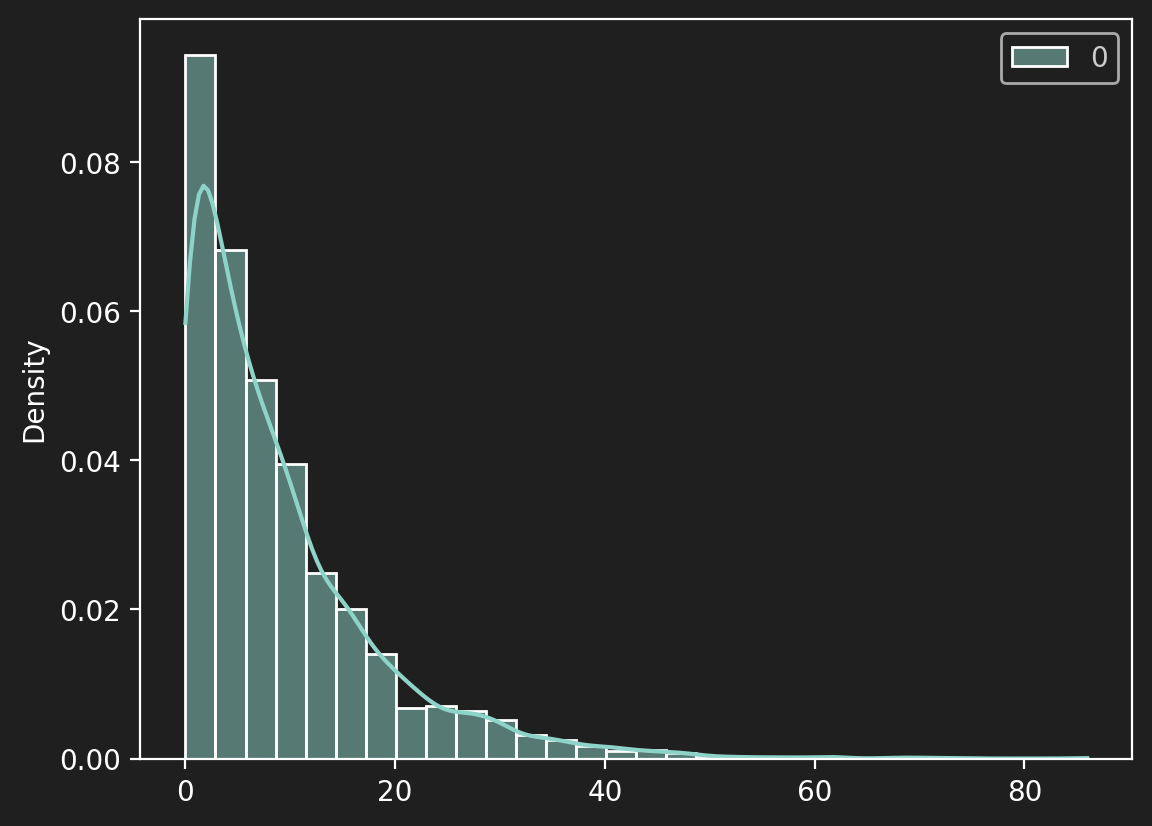

In [15]:
@jax.jit
def example_ptd_spec(a, b):
    alpha = jnp.array([1.0, 0.0])
    T = jnp.array([[1-a-b, a],
                    [0.0, 1-a]])

    row_sums = jnp.sum(T, axis=1)
    t1 = 1 - row_sums
    t_vecs = [t1] 
    return alpha, T, t_vecs


# @jax.jit
# def example_ptd_spec(a, b):
#     alpha = jnp.array([1.0, 0.0, 0.0])
#     T = jnp.array([[1-(a+b)/1, a/1, b/1],
#                     [0.0, 1-b/10, 0.0],
#                     [0.0, 0.0, 1-a/10]])

#     row_sums = jnp.sum(T, axis=1)
#     t1 = 1 - row_sums
#     jax.debug.print("🤯 {}", t1)
#     t_vecs = [t1] 
#     return alpha, T, t_vecs


# @jax.jit
# def example_ptd_spec(a, b):
#     alpha = jnp.array([1.0, 0.0])
#     T = jnp.array([[1-b, a],
#                     [0.0, 1-a]])
#     row_sums = jnp.sum(T, axis=1)
#     t1 = 1 - row_sums
#     # t1 = jnp.array([1-b-a, a])
#     t_vecs = [t1] 
#     return alpha, T, t_vecs


def simulate_example_data(a, b, samples=None, data_dims=None, key=None):

    assert data_dims in [1]  # number of data dimensions

    if key is None:
        key = jax.random.key(int(time() * 1e6))

    alpha, T, t_vecs = example_ptd_spec(a, b)

    nr_states = T.shape[0]

    k = len(t_vecs)
    t_vecs_stacked = jnp.stack(t_vecs, axis=0)  # shape (k, m)

    def single_sample(key):
        key, subkey = jax.random.split(key)
        state = jax.random.choice(subkey, nr_states, p=alpha)

        def cond_fn(carry):
            _, _, _, absorbed = carry
            return ~absorbed

        def body_fn(carry):
            key, state, t, _ = carry
            key, *subkeys = jax.random.split(key, num=k + 2)

            draws = jnp.array([
                jax.random.uniform(subkeys[i]) < t_vecs_stacked[i, state]
                for i in range(k)
            ])
            absorbed = jnp.any(draws)

            if data_dims == 2:
                incr = jnp.zeros(data_dims, dtype=int)
                incr = incr.at[state].set(1)
            else:
                incr = 1
                
            # update discrete events if not absorbed
            t_new = jax.lax.cond(absorbed, lambda t_: t_, lambda t_: t_ + incr, t)
            # jax.debug.print("🤯 {}", t_new)

            state_new = jax.lax.cond(
                absorbed,
                lambda s: s,
                lambda s: jax.random.choice(subkeys[-1], nr_states, p=T[s]),
                operand=state
            )

            return key, state_new, t_new, absorbed

        init_carry = (key, state, jnp.zeros(data_dims, dtype=int), False)

        _, _, t_final, _ = jax.lax.while_loop(cond_fn, body_fn, init_carry)
        return t_final

    keys = jax.random.split(key, samples)
    return jax.vmap(single_sample)(keys)

data = simulate_example_data(0.1, 0.1, samples=10000, data_dims=1, key=jax.random.key(0))

if data.shape[1] == 2:
    unique, counts = np.unique(data, axis=0, return_counts=True)
    counts_matrix = np.zeros((data.max()+1, data.max()+1))
    #print(counts_matrix)
    counts_matrix[:] = np.nan
    for idx, count in zip(unique, counts):
        counts_matrix[(idx[0], idx[1])] = count
    #print(counts_matrix)
    cmap = iridis
    cmap.set_bad(color='none')
    ax = plt.imshow(counts_matrix[:50, :50], cmap=cmap, origin='lower')
else:
    sns.histplot(data, bins=30, kde=True, stat='density')

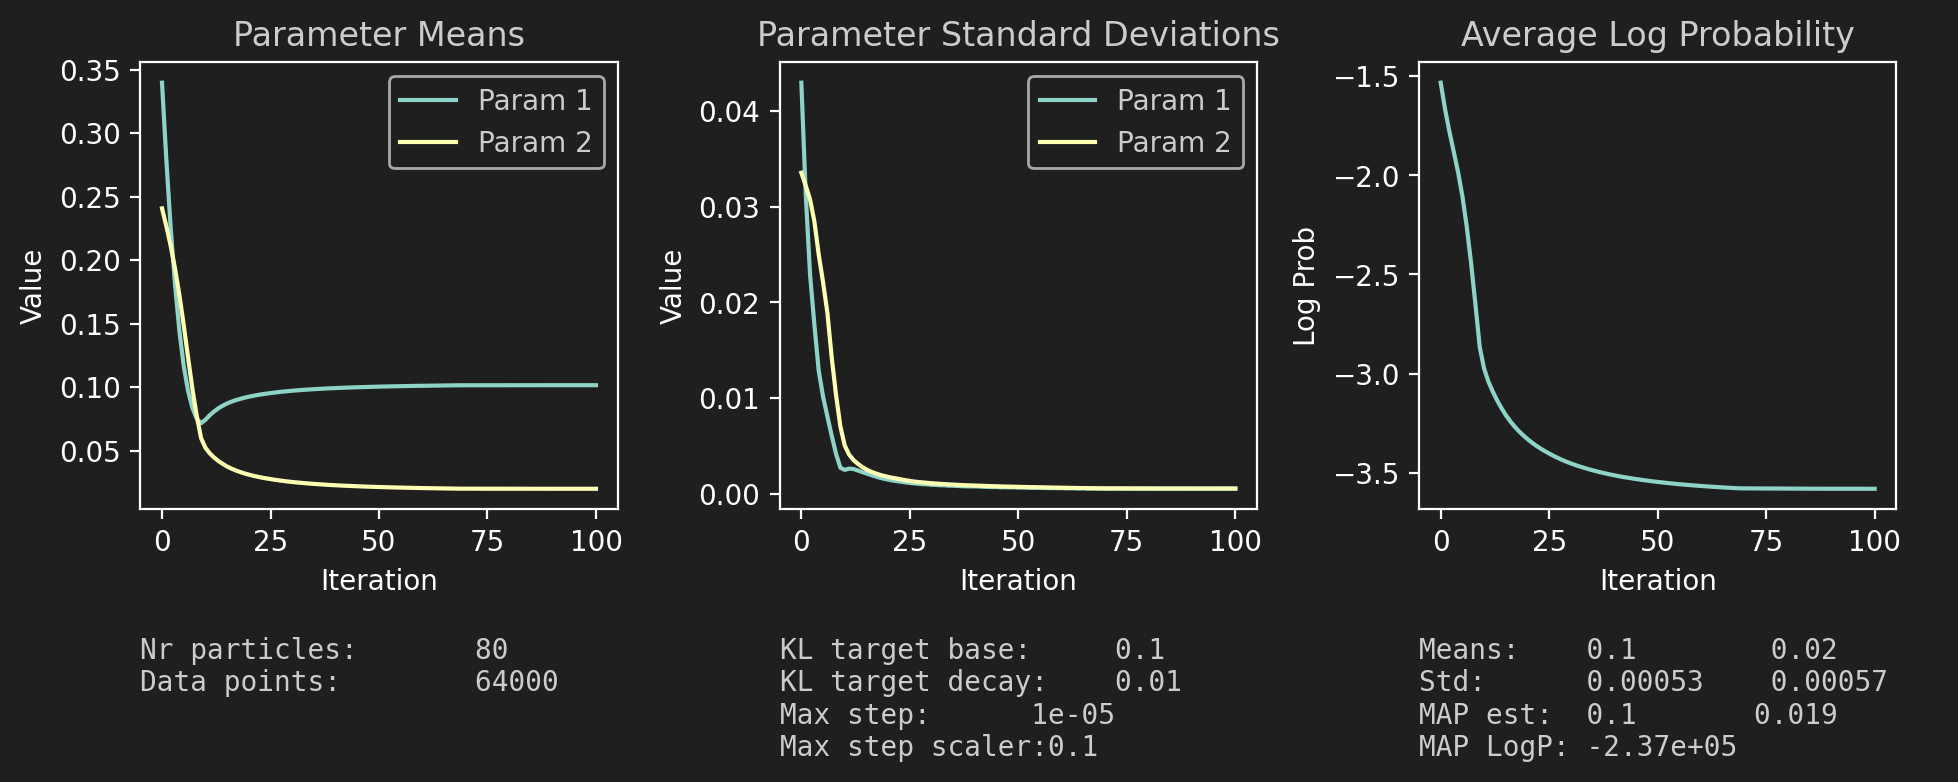

In [19]:
@jax.jit
def unpack_theta(theta):
    # no vector or matrix variables, so just return values as list
    return tuple([jnp.array(x) for x in theta])

@jax.jit
def log_pmf_dph(z, theta):
    """
    Fully static version for JIT compilation
    """

    a, b = theta
    alpha, T, t_vecs = example_ptd_spec(a, b)
    m = T.shape[0]
    k = len(t_vecs)

    # Use fixed upper bound
    z_max = 50
    t_mat = jnp.stack(t_vecs, axis=1)  # shape (m, k)

    def body_fun(i, carry):
        Tk, probs = carry
        out = alpha @ Tk @ t_mat
        Tk_next = Tk @ T
        return Tk_next, probs.at[i].set(out)

    Tk0 = jnp.eye(m)
    probs_init = jnp.zeros((z_max, k))
    _, probs_filled = jax.lax.fori_loop(0, z_max, body_fun, (Tk0, probs_init))

    # Ensure z is properly shaped and clipped
    z_clipped = jnp.clip(z.astype(int), 0, z_max - 1)
    # jax.debug.print("🤯 z: {} z_clipped: {}", z, z_clipped)

    # Use a fully vectorized approach without conditionals
    # Pad z_clipped to always have k elements (for univariate case)
    z_padded = jnp.pad(z_clipped, (0, max(0, k - len(z_clipped))))[:k]
    
    # Use advanced indexing with static shapes
    indices = jnp.arange(k)
    prob_at_z = probs_filled[z_padded, indices]
    logp = jnp.sum(jnp.log(jnp.maximum(prob_at_z, 1e-12)))
    
    return logp

# Use adaptive kernel bandwidth
@jax.jit
def median_heuristic(particles):
    """Compute bandwidth using median heuristic"""
    pairwise_dist = jnp.sum((particles[:, None, :] - particles[None, :, :])**2, axis=-1)
    h = jnp.median(pairwise_dist) / (2 * jnp.log(particles.shape[0] + 1))
    return h

# Local bandwidth adjustment: For highly multimodal distributions, consider
# using particle-specific bandwidths that adapt to local density:
@jax.jit
def local_adaptive_bandwidth(particles, k=5):
    """Compute local bandwidth for each particle based on k nearest neighbors"""
    # Compute pairwise distances
    pairwise_dist = jnp.sum((particles[:, None, :] - particles[None, :, :])**2, axis=-1)
    
    # For each particle, find distance to k-th nearest neighbor
    sorted_dist = jnp.sort(pairwise_dist, axis=1)
    kth_neighbor_dist = sorted_dist[:, k]

    # Set bandwidth proportional to distance to k-th neighbor
    local_h = kth_neighbor_dist / (2 * jnp.log(k + 1))
    return local_h

# Batch-based bandwidth estimation: For very large datasets, compute the
# bandwidth using a random subset of the data to improve computational
# efficiency:
@jax.jit
def batch_median_heuristic(particles, max_particles=1000):
    """Compute bandwidth using a subset of particles for large sample sizes"""
    if len(particles) > max_particles:
        idx = np.random.choice(len(particles), max_particles, replace=False)
        particles_subset = particles[idx]
    else:
        particles_subset = particles
        
    pairwise_dist = jnp.sum((particles_subset[:, None, :] - particles_subset[None, :, :])**2, axis=-1)
    h = jnp.median(pairwise_dist) / (2 * jnp.log(max_particles + 1))
    return h

@jax.jit
def rbf_kernel(x, h):
    pairwise_dists = jnp.sum((x[:, None, :] - x[None, :, :]) ** 2, axis=-1)
    kxy = jnp.exp(-pairwise_dists / h)
    dxkxy = -2.0 / h * (x[:, None, :] - x[None, :, :]) * kxy[:, :, None]
    return kxy, dxkxy

@jax.jit
def rbf_kernel_median(x, h=-1):
    sq_dist = jnp.sum((x[:, None, :] - x[None, :, :])**2, axis=-1)
    h = jnp.median(sq_dist)
    h = jnp.where(h <= 0.0, 1.0, h)
    h = h / jnp.log(x.shape[0] + 1.0)
    k = jnp.exp(-sq_dist / h)
    grad_k = -(x[:, None, :] - x[None, :, :]) * k[:, :, None] * 2.0 / h
    return k, grad_k

# @jax.jit
# def rbf_kernel_local(X, neighbors=5):
#     pairwise_dists = jnp.sum((X[:, None, :] - X[None, :, :])**2, axis=-1)
#     local_bandwidths = local_adaptive_bandwidth(X, k=neighbors)
#     # Compute average bandwidths between all pairs: (n_particles, n_particles)
#     h_matrix = 0.5 * (local_bandwidths[:, None] + local_bandwidths[None, :])
#     h = h_matrix
#     K = jnp.exp(-pairwise_dists / h)
#     grad_K = -2 / h * (X[:, None, :] - X[None, :, :]) * K[:, :, None]
#     return K, grad_K

@jax.jit
def logp(theta):
    theta = unpack_theta(theta)
    log_prob = jnp.sum(vmap(lambda x: log_pmf_dph(x, theta))(data))
    return log_prob

@jax.jit
@partial(jax.vmap, in_axes=(0,))
def logp_z(z):
    theta = z_to_theta(z)         
    return jnp.sum(vmap(lambda z_i: log_pmf_dph(z_i, theta))(data))

@jax.jit
def kl_adaptive_step(phi, kl_target=0.1, min_step=1e-7, max_step=1.0):
    norm_sq = jnp.sum(phi ** 2, axis=1)
    mean_norm_sq = jnp.mean(norm_sq)
    eta = jnp.sqrt((2.0 * kl_target) / (mean_norm_sq + 1e-8))

    return jnp.maximum(jnp.minimum(eta, max_step), min_step)

@jax.jit
def decayed_kl_target(t, base=0.1, decay=0.01):
    return base * jnp.exp(-decay * t)

@jax.jit
def step_size_schedule(i, steps=None, initial=None, final=None):
    """Cosine annealing schedule for step size"""
    return final + 0.5 * (initial - final) * (1 + jnp.cos(jnp.pi * i / steps))

@jax.jit
def z_to_theta(z):
    return decoder(z)


def update_fixed_bw_fixed_step(logp_fn, particles_z, h=0.01, step=0.001):
    grads = vmap(grad(logp_fn))(particles_z)
    K, grad_K = rbf_kernel(particles_z, h)
    phi = (K @ grads + jnp.sum(grad_K, axis=1)) / particles_z.shape[0]
    return particles_z + step * phi


def update_median_bw_fixed_step(logp_fn, particles_z, step=0.001):
    grads = vmap(grad(logp_fn))(particles_z)
    K, grad_K = rbf_kernel_median(particles_z)
    phi = (K @ grads + jnp.sum(grad_K, axis=1)) / particles_z.shape[0]
    return particles_z + step * phi

@jax.jit
def update_median_bw_kl_step(particles_z, kl_target=0.01, max_step=1.0):

    def logp_z(z):
        theta = z_to_theta(z)         
        return jnp.sum(vmap(lambda z_i: log_pmf_dph(z_i, theta))(data))

    #phi = svgd_phi(logp_fn, particles_z)
    score = vmap(grad(logp_z))(particles_z)
    kxy, dxkxy = rbf_kernel_median(particles_z)
    phi = (kxy @ score + jnp.sum(dxkxy, axis=1)) / particles_z.shape[0]

    eta = kl_adaptive_step(phi, kl_target, max_step=max_step)
    return particles_z + eta * phi      

@jax.jit
def update_local_bw_kl_step(particles, neighbors=None, kl_target=None, max_step=None):
    """
    Vectorized implementation of SVGD with adaptive bandwidth
    
    Args:
        particles: array of shape (n_particles, dim)
        grad_log_prob: function that computes gradient of log probability
        step_size: learning rate for the update
        
    Returns:
        Updated particles after one SVGD step
    """

    def logp_z(z):
        theta = z_to_theta(z)         
        return jnp.sum(vmap(lambda z_i: log_pmf_dph(z_i, theta))(data))
    

    # Compute local bandwidths for each particle
    local_bandwidths = local_adaptive_bandwidth(particles)
    
    # Compute gradients of log probability for all particles
    log_prob_grads = jax.vmap(jax.grad(logp_z))(particles)
    
    # Number of particles
    n_particles = particles.shape[0]
    
    # Compute pairwise differences between particles: (n_particles, n_particles, dim)
    pairwise_diff = particles[:, None, :] - particles[None, :, :]
    
    # Compute pairwise squared distances: (n_particles, n_particles)
    pairwise_dist_sq = jnp.sum(pairwise_diff**2, axis=-1)
    
    # Compute average bandwidths between all pairs: (n_particles, n_particles)
    h_matrix = 0.5 * (local_bandwidths[:, None] + local_bandwidths[None, :])
    
    # Compute kernel matrix: (n_particles, n_particles)
    kernel_matrix = jnp.exp(-0.5 * pairwise_dist_sq / h_matrix)
    
    # Compute kernel-weighted average of gradients (kernel term)
    # Fix: Use direct matrix multiplication instead of einsum
    kernel_term_sum = jnp.matmul(kernel_matrix, log_prob_grads) / n_particles
    
    # Compute gradient of kernel w.r.t. particles (repulsive term)
    grad_kernel = (kernel_matrix[:, :, None] * pairwise_diff) / h_matrix[:, :, None]
    
    # Sum over particles j: (n_particles, dim)
    repulsive_term_sum = jnp.sum(grad_kernel, axis=1) / n_particles
    
    # Combine terms for the SVGD update
    phi = kernel_term_sum + repulsive_term_sum
    
    step_size = kl_adaptive_step(phi, kl_target, max_step=max_step)

    # Update particles
    updated_particles = particles + step_size * phi
    
    return updated_particles


@pjit
def distributed_svgd_step(x, kl_target, max_step, neighbors):
    # return update_median_bw_kl_step(x, kl_target=kl_target, max_step=max_step)
    return update_local_bw_kl_step(x, kl_target=kl_target, max_step=max_step, neighbors=neighbors)


# N^(-1/(4+d))


# def run_svgd():

key = jax.random.key(0)

a, b = 0.1, 0.02 # True parameters for the PTD
theta = [a, b]
data_dims = 1
samples = 64000
#### Data generation ####
data = simulate_example_data(*theta, 
                            #   samples=256, 
                            #  samples=2048*32, 
                             samples=samples, 
                             data_dims=data_dims,
                              key=key)

# ## Data sharding
# nr_cpus = 8
# devices = jax.devices("cpu")[:nr_cpus]  # assume at least 8 CPU devices
# mesh = jsh.Mesh(devices, axis_names=("cpu",))
# # Shard over 16 logical shards -> 'logical_cpu_shard' axis
# # This uses the same 8 physical devices repeatedly
# sharding = jsh.NamedSharding(mesh, jsh.PartitionSpec("cpu", None))
# # Reshape into 16 shards before device_put
# data = jax.device_put(_data.reshape(nr_cpus, -1), sharding)

#### SVGD ####

n_particles = 80
n_iter = 100
n_devices = 8
kl_target_base = 0.1
kl_target_decay = 0.01
neighbors = 50
max_step = 0.001
min_step = 1e-5
max_step_scaler = 0.1

if n_particles % n_devices != 0:
    raise ValueError("n_particles must be divisible by number of devices")

# transform decoder
decoder = IndependentProbDecoder(latent_dim=len(theta), key=key) # used by z_to_theta

# initial particles
particles_z = jax.random.uniform(key, shape=(n_particles, len(theta)), minval=0, maxval=1)

# shard particles over devices
devices = mesh_utils.create_device_mesh((n_devices,))
mesh = Mesh(devices, axis_names=("i",))
sharding = NamedSharding(mesh, P("i", None))  # Shard only over the first axis
particles_z = jax.device_put(particles_z, sharding)

# svgd iterations
particle_z_history, every = [particles_z], 1
prev = None
with mesh:
    for i in trange(n_iter):
        kl_target = decayed_kl_target(i, base=kl_target_base, decay=kl_target_decay) 
        particles_z = distributed_svgd_step(particles_z, neighbors=neighbors, kl_target=kl_target, max_step=max_step)

        assert kl_target > 1e-8

        this = jnp.median(vmap(lambda z: logp_z(z))(particles_z[None, :, :]), axis=1)
        if prev is not None and this < prev:
            max_step = max(max_step * max_step_scaler, min_step)
        prev = this

        if not i % every:
            particle_z_history.append(particles_z)


particle_history = np.array([vmap(lambda z: z_to_theta(z))(p) for p in particle_z_history])
particle_z_history = np.array(particle_z_history)

particles = jnp.array([z_to_theta(z) for z in particles_z])

p1, p2 = 0, 1
map_point, map_log_prob = map_estimate_from_particles(particles, logp)
a_mean = jnp.mean(particles[:, p1], axis=0)
b_mean = jnp.mean(particles[:, p2], axis=0)
a_std = jnp.std(particles[:, p1], axis=0)
b_std = jnp.std(particles[:, p2], axis=0)
text = [
    '\n'.join([
        f"{'Nr particles:'.ljust(20)}{n_particles:<10}",
        f"{'Data points:'.ljust(20)}{data.shape[0]:<10}",
    ]),
    '\n'.join([
        f"{'KL target base:'.ljust(20)}{kl_target_base:<10}",
        f"{'KL target decay:'.ljust(20)}{kl_target_decay:<10}",
        f"{'Max step:'.ljust(15)}{max_step:<10}",
        f"{'Max step scaler:'.ljust(15)}{max_step_scaler:<10}",
    ]),
    '\n'.join([
        f"{'Means:'.ljust(10)}{a_mean:<10.2} {b_mean:<10.2}", 
        f"{'Std:'.ljust(10)}{a_std:<10.2} {b_std:<10.2}", 
        f"{'MAP est:'.ljust(10)}{map_point[p1]:<10.2}{map_point[p2]:<10.2}",
        f"{'MAP LogP:'.ljust(10)}{map_log_prob:<10.2e}"
    ]),
]
check_convergence(particle_history, log_pmf_dph, data, every=every, text=text)

In [20]:
# particle animation
# (you can skip the first couple frames to shrink plotted range)
animate_svgd_2d(particle_history, true_params=[a, b], skip=0,
                 save_as_gif='tmp.gif', save_as_mp4='tmp.mp4',
                 figsize=(5, 5), labels=["Parameter 1", "Parameter 2"],
                 title="SVGD Particle Evolution")

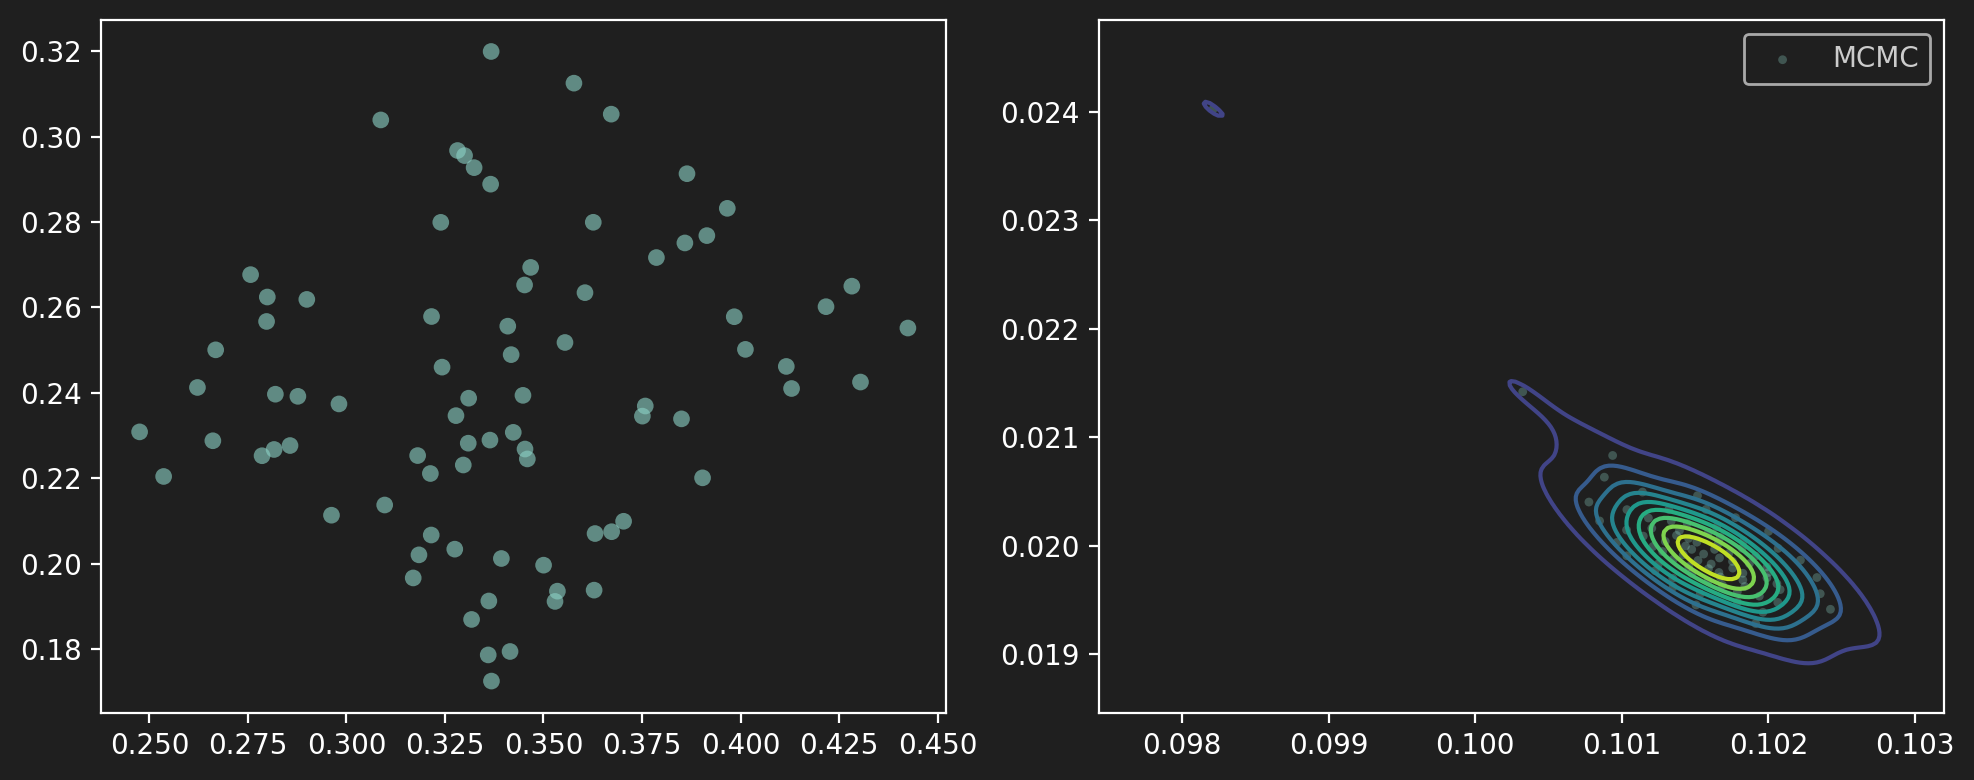

In [21]:
p_idx = (0, 1) # indices of the parameters to plot

plt.figure(figsize=(10, 4))
# plot initial particles
a_init, b_init = particle_history[0]
plt.subplot(1, 2, 1)
plt.scatter(a_init, b_init, edgecolor='none', alpha=0.6, label='Initial')
# plot final particles
a_final, b_final = particles[:, p_idx[0]], particles[:, p_idx[1]]
plt.subplot(1, 2, 2)
sns.scatterplot(x=a_final, y=b_final, edgecolor='none', alpha=0.3, s=10, label='MCMC')
sns.kdeplot(x=a_final, y=b_final, cmap=iridis)    
plt.tight_layout()

MAP estimate: [0.10191336 0.01928067], log probability: -236672.984375
HDR contains 76 particles out of 80
HDR log probability threshold: -236679.65625


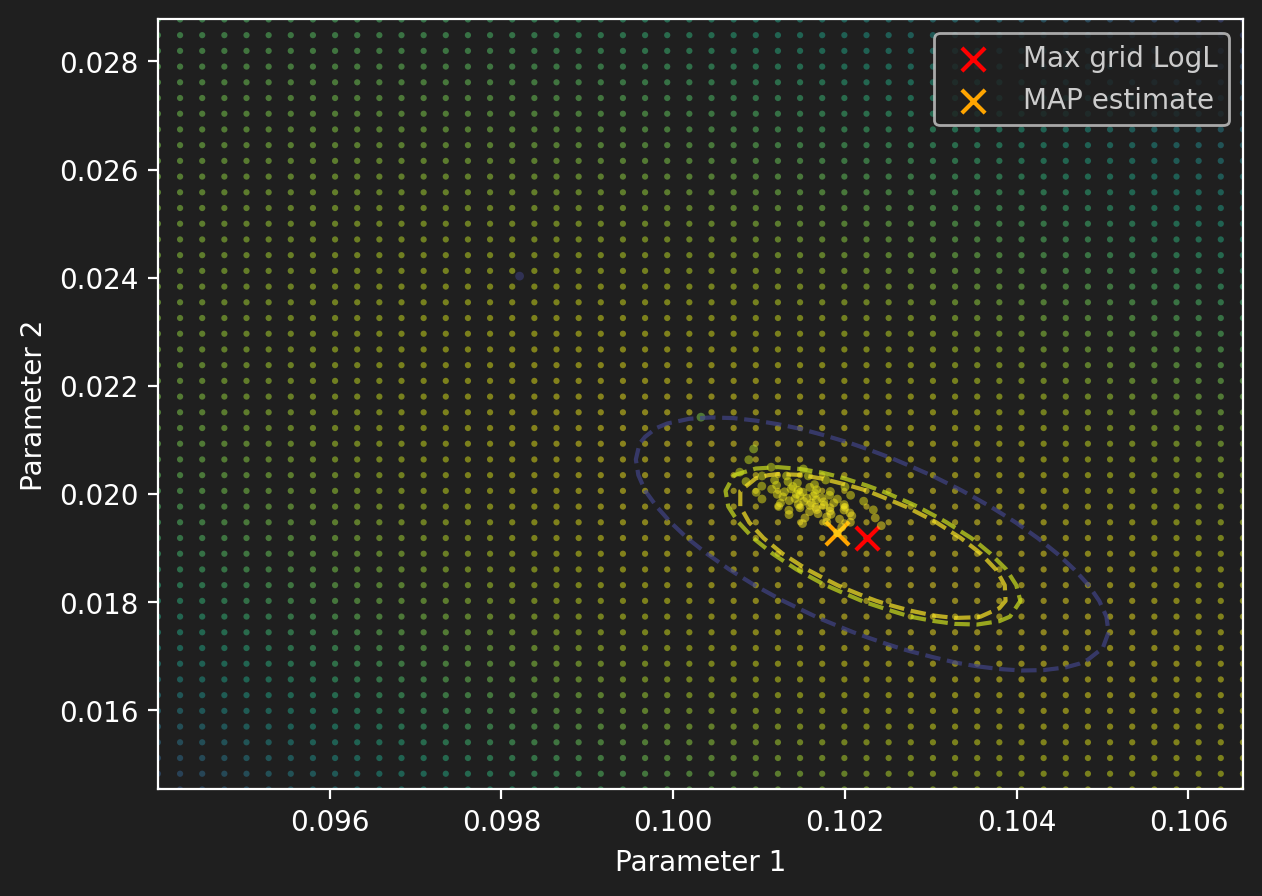

In [22]:


# Find MAP estimate
map_point, map_log_prob = map_estimate_from_particles(particles, logp)
print(f"MAP estimate: {map_point}, log probability: {map_log_prob}")

# # Refine with optimization
# refined_map, refined_log_prob = map_estimate_with_optimization(particles, logp)
# print(f"Refined MAP: {refined_map}, log probability: {refined_log_prob}")

# Get HDR
hdr_particles, threshold = estimate_hdr(particles, logp, alpha=0.95)
print(f"HDR contains {len(hdr_particles)} particles out of {len(particles)}")
print(f"HDR log probability threshold: {threshold}")

alphas=[0.90, 0.95, 0.99]
# idx = [0, 1]  # Indices of the dimensions to visualize

def logp(theta):
    return jnp.sum(vmap(lambda x: log_pmf_dph(x, theta))(data))

fig = visualize_hdr_2d(particles, logp, idx=p_idx, grid_size=50, 
                       alphas=alphas, margin=1)


[0.1, 0.02]


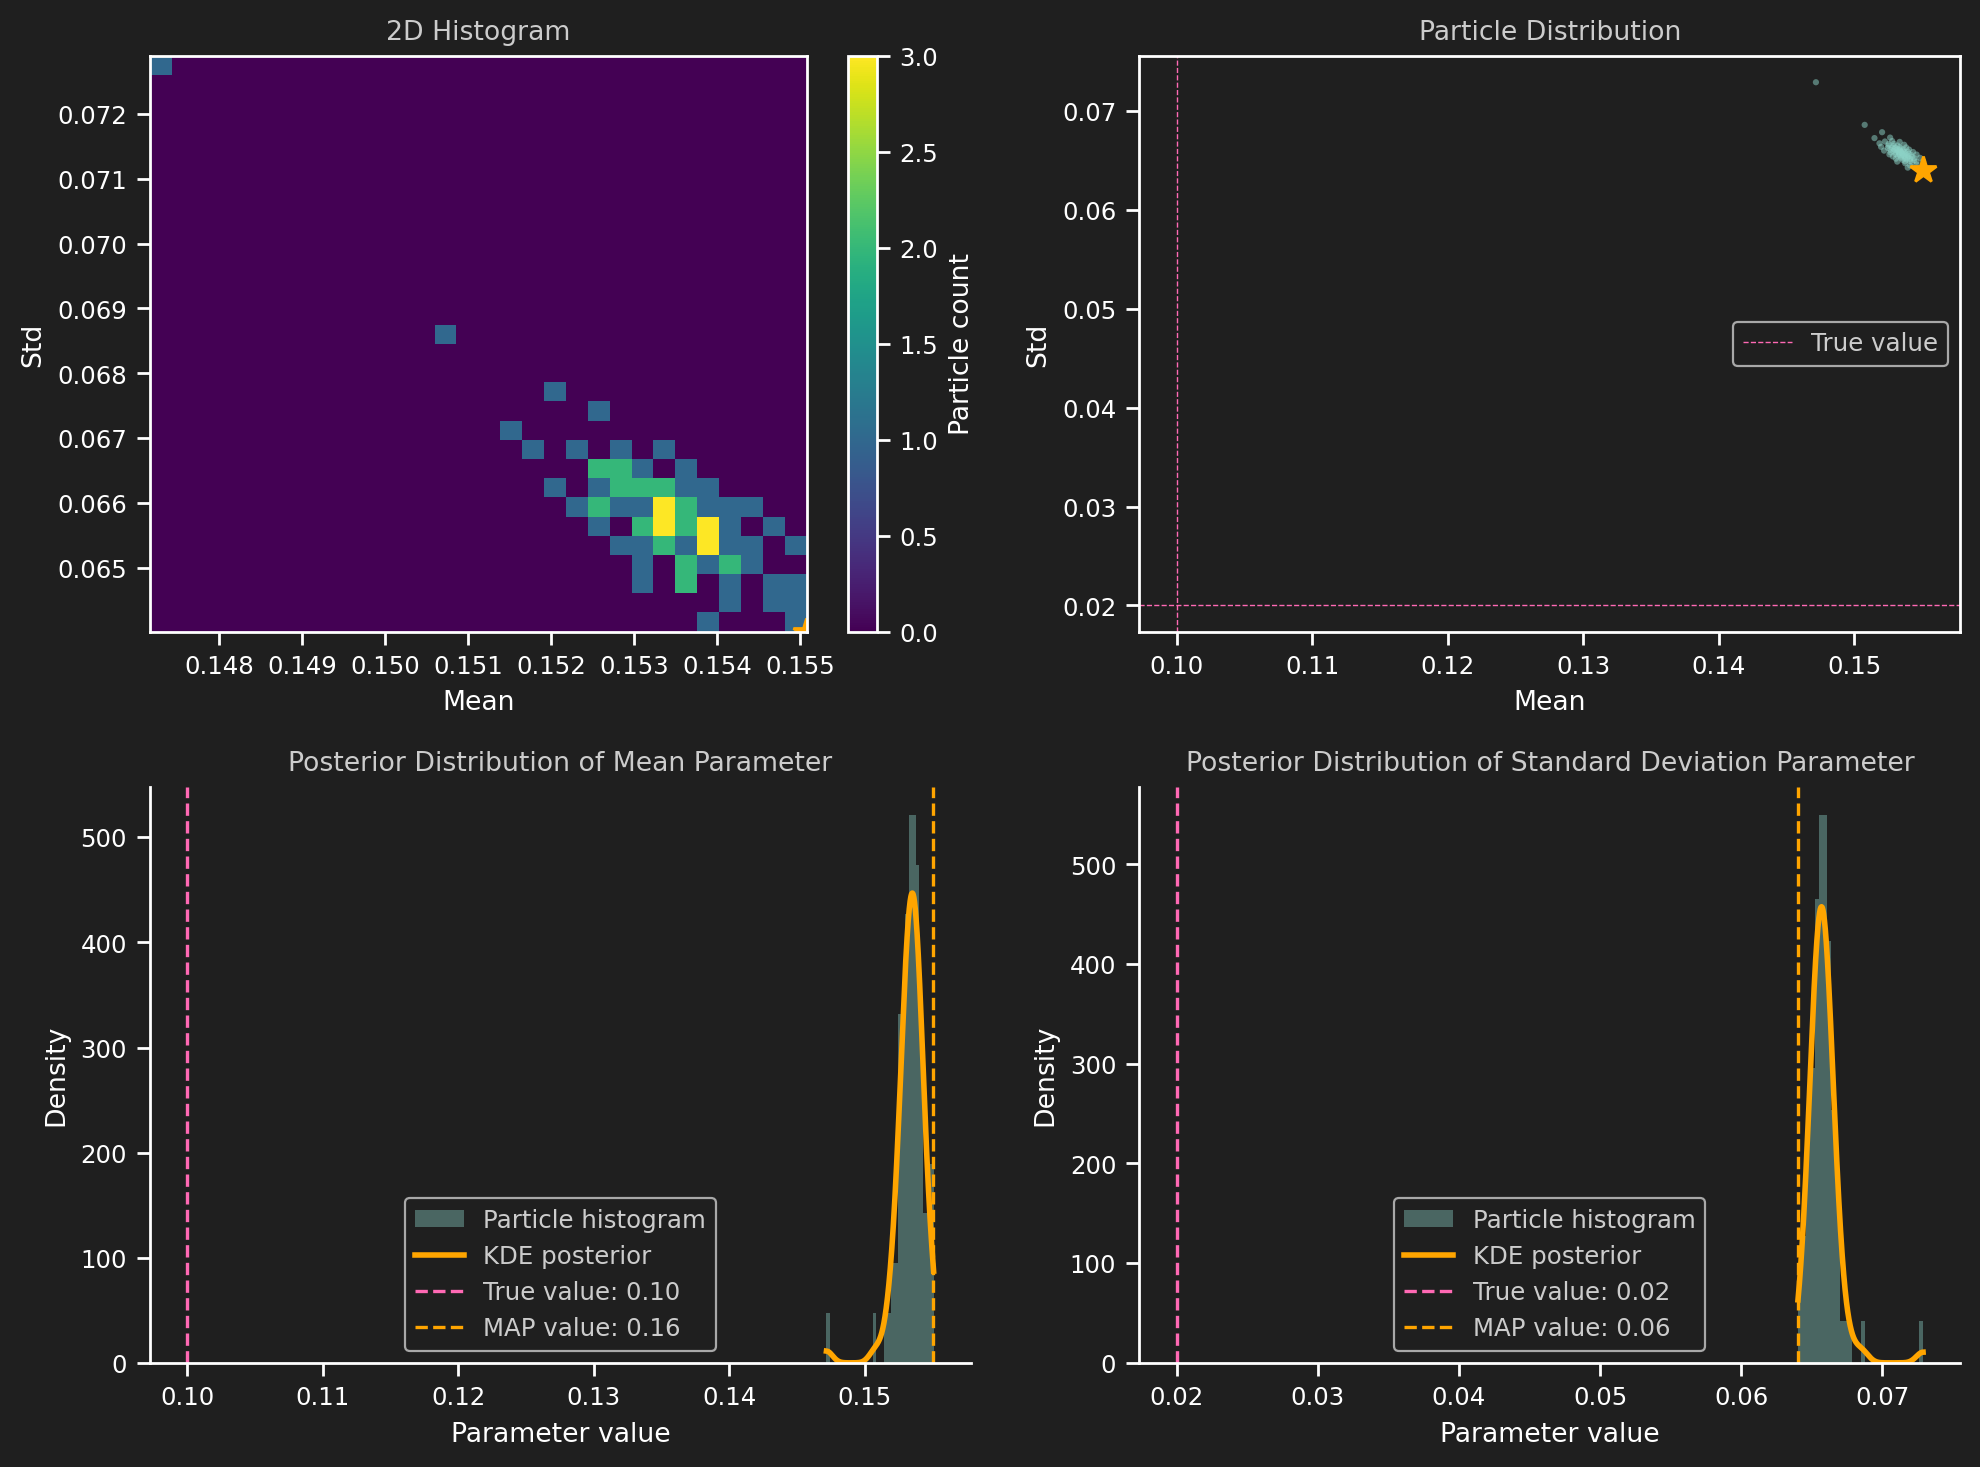

In [30]:
sns.set_context('paper')
# Plot the final posterior approximation
plot_svgd_posterior_2d(
    particles,  # Convert to numpy if using JAX arrays
    idx=p_idx,  # Indices of the parameters to plot
    true_params=[a, b],  # True parameters that generated the data
    # obs_stats=[data[:, 0].mean(), data[:, 1].std()],
    map_est=map_point.tolist(),
    labels=["Mean", "Std"],
)

In [ ]:
#!/bin/bash
#SBATCH --ntasks=10
#SBATCH --cpus-per-task=1
#SBATCH --job-name=jax_dist
#SBATCH --time=01:00:00
#SBATCH --output=out_%j.log

# #SBATCH --nodes=20
# #SBATCH --ntasks-per-node=1
# #SBATCH --cpus-per-task=4

# # Load necessary modules
# module load cuda/12.1
# module load python/3.10  # or activate your env

# coordinator_address must be a globally routable IP or hostname (not 127.0.0.1).
# Make sure NCCL_SOCKET_IFNAME is set to an appropriate network interface
(typically ^lo,docker0 to exclude localhost and docker).
# You can replace srun with mpirun or torchrun if more control is needed, but
SLURM-native srun is preferred for tight integration.
# Avoid hard-coding GPU IDs. jax_local_device_ids="auto" lets JAX select all
local devices

# Define coordinator (rank 0 host and port)
COORDINATOR_HOST=$(scontrol show hostnames $SLURM_JOB_NODELIST | head -n 1)
COORDINATOR_PORT=12345

# Set environment variables
export NCCL_SOCKET_IFNAME=^lo,docker0
export NCCL_DEBUG=INFO

# # Launch one process per GPU using srun
# srun --cpu_bind=none --accel-bind=gn \
#   bash -c 'pixi run python YOUR_JAX_SCRIPT.py slurm \
#     --jax_process_index=$SLURM_PROCID \
#     --jax_process_count=$SLURM_NTASKS \
#     --jax_local_device_ids=auto \
#     --coordinator_address='"$COORDINATOR_HOST:$COORDINATOR_PORT"

pixi run python YOUR_JAX_SCRIPT.py slurm \
    --jax_process_index=$SLURM_PROCID \
    --jax_process_count=$SLURM_NTASKS \
    --jax_local_device_ids=auto \
    --coordinator_address='"$COORDINATOR_HOST:$COORDINATOR_PORT"


In [ ]:
import argparse
import jax.distributed

def main():

    # create the top-level parser
    parser = argparse.ArgumentParser()
    parser.add_argument('--foo', action='store_true', help='foo help')
    subparsers = parser.add_subparsers(help='subcommand help')

    # create the parser for the "slurm" command
    parser_slurm = subparsers.add_parser('slurm', help='a help')
    parser_slurm.add_argument("--jax-process-index", type=int, required=True)
    parser_slurm.add_argument("--jax-process-count", type=int, required=True)
    parser_slurm.add_argument("--jax_local_device_ids", type=str, default="auto")
    parser_slurm.add_argument("--coordinator-address", type=str, required=True)

    # # create the parser for the "b" command
    # parser_b = subparsers.add_parser('b', help='b help')
    # parser_b.add_argument('--baz', choices=('X', 'Y', 'Z'), help='baz help')

    args = parser.parse_args()

    if args.coordinator_address:
        # script is envoked with on slurm using the batch script above
        jax.distributed.initialize(
            coordinator_address=args.coordinator_address,
            num_processes=args.jax_process_count,
            process_id=args.jax_process_index,
            local_device_ids=args.jax_local_device_ids,
        )

        # Example distributed computation
        print(f"Running process {jax.process_index()} of {jax.process_count()}")
        print(f"Devices: {jax.local_devices()}")

    run_svgd()

decoder = None
particles = None
particle_history = None

#######################################################
############## FUNCTIONS FROM CELL BELOW ############## 
#######################################################


def run_svgd():

    global decoder, particles, particle_history

    ###################################################
    ############## BODY FROM CELL BELOW ###############
    ###################################################

if __name__ == "__main__":
    main()